In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
import logging

mpl.rcParams['figure.dpi'] = 150
logging.disable(logging.CRITICAL)


### Loading Dataset

In [7]:
# Get energy data from ENTSO-E API
country_code = 'ES'
area = lookup_area(country_code)

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(weeks = 2)
%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
df_energy = df_energy.resample('H').mean()
df_energy.tail()

Wall time: 10.7 s


,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
2022-07-11 14:00:00,497.0,0.0,0.0,13893.0,1242.0,80.0,0.0,0.0,0.0,-197.0,559.0,560.0,0.0,6904.0,61.0,88.0,11244.0,228.0,0.0,4275.0
2022-07-11 15:00:00,495.0,0.0,0.0,14234.0,1243.0,80.0,0.0,0.0,0.0,0.0,574.0,744.0,0.0,6898.0,60.0,85.0,10407.0,227.0,0.0,4543.0
2022-07-11 16:00:00,496.0,0.0,0.0,13777.0,1244.0,80.0,0.0,0.0,0.0,-60.0,569.0,827.0,0.0,6903.0,48.0,89.0,9389.0,230.0,0.0,4893.0
2022-07-11 17:00:00,502.0,0.0,0.0,14128.0,1244.0,81.0,0.0,0.0,0.0,-29.0,588.0,924.0,0.0,6912.0,58.0,92.0,7472.0,231.0,0.0,5498.0
2022-07-11 18:00:00,506.0,0.0,0.0,14482.0,1244.0,108.0,0.0,0.0,0.0,0.0,651.0,1530.0,0.0,6917.0,58.0,94.0,4090.0,226.0,0.0,6274.0


### Forecasting with PyCaret

In [3]:
ts = setup(data = df_energy['Solar'], fh = 48,
           enforce_exogenous = False, fold = 3)
           

,Description,Value
0,session_id,5454
1,Target,Solar
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(335, 1)"
5,Transformed data shape,"(335, 1)"
6,Transformed train set shape,"(287, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [4]:
model = create_model('auto_arima', cross_validation = False, engine = 'statsforecast')

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,5.9785,3.6151,386.1725,597.1711,274597604779692.5938,1.0647,0.6606


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

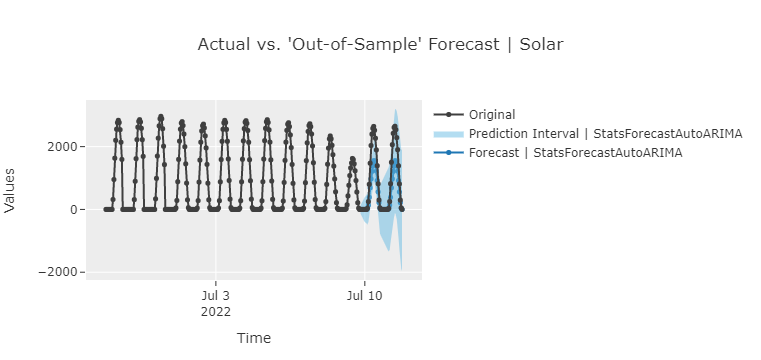

In [5]:
fig_kwargs = {'renderer': 'jupyterlab'}

plot_model(model, 'forecast', fig_kwargs = fig_kwargs)

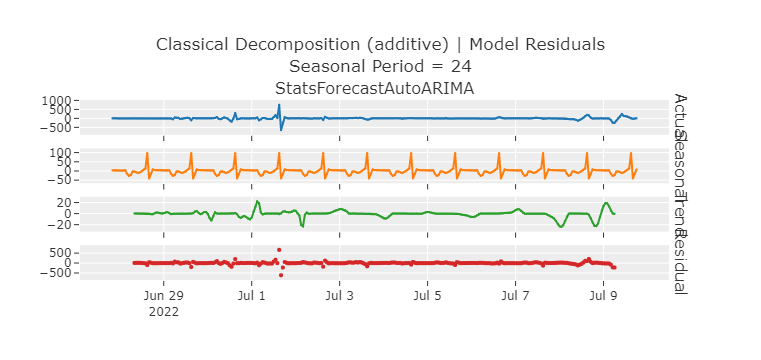

In [6]:
plot_model(model, 'decomp', fig_kwargs = fig_kwargs)